In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../Data/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq='MS'

In [3]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

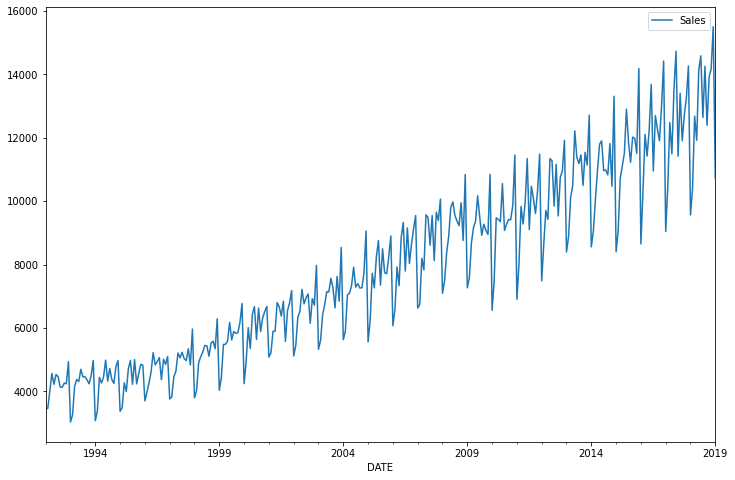

In [4]:
df.plot(figsize=(12,8))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

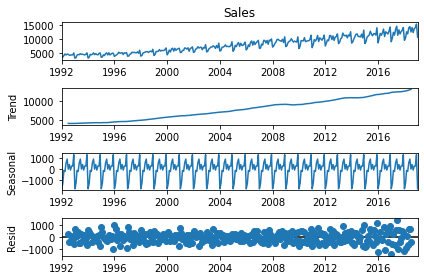

In [6]:
result = seasonal_decompose(df['Sales'])
result.plot();

In [7]:
len(df)

325

In [8]:
train=df.iloc[:313]; test=df.iloc[313:]

In [9]:
test

,Sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


In [11]:
# scale the data
from sklearn.preprocessing import MinMaxScaler

In [12]:
scalar = MinMaxScaler()
scalar.fit(train)

MinMaxScaler()

In [13]:
scaled_train = scalar.transform(train)
scaled_test = scalar.transform(test)

### using Keras timeseries generator

generating batches of the timeseries along with the labels

In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [27]:
n_input = 3 # larger the number of inputs will let the NN get an idea of the seasonality cycle
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [25]:
X,y = generator[0]
print(X,y)

[[[0.03658432]
  [0.03649885]]] [[0.08299855]]


In [26]:
scaled_train[:5]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ]])

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [31]:
n_input = 12 # larger the number of inputs will let the NN get an idea of the seasonality cycle
n_features = 1
train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [33]:
model = Sequential()

model.add(LSTM(150,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit_generator(train_generator,epochs=25)

/Users/kiran/Desktop/Data_Science_Projects/venv/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
301/301 [==============================] - 5s 9ms/step - loss: 0.0414
Epoch 2/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0080
Epoch 3/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0090
Epoch 4/25
301/301 [==============================] - 3s 10ms/step - loss: 0.0082
Epoch 5/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0061
Epoch 6/25
301/301 [==============================] - 3s 10ms/step - loss: 0.0049
Epoch 7/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0036
Epoch 8/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0025
Epoch 9/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0034
Epoch 10/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0023
Epoch 11/25
301/301 [==============================] - 2s 8ms/step - loss: 0.0023
Epoch 12/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0017
Epoch 13/25
301/301 

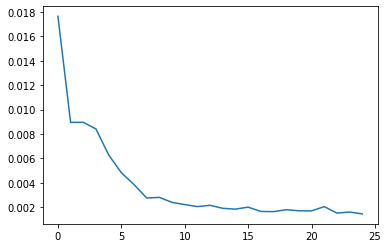

In [38]:
my_loss = model.history.history['loss']
plt.plot(range(len(my_loss)),my_loss)

In [47]:
# Evaluating the model
# 12 points -> 13th point
first_evaluation_batch = scaled_train[-12:]
first_evaluation_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

need to correct the shape to match the shape of X in train generator

In [49]:
first_evaluation_batch = np.reshape(first_evaluation_batch,(1,n_input,n_features))
first_evaluation_batch.shape

(1, 12, 1)

In [41]:
train_generator[0][0].shape

(1, 12, 1)

In [45]:
model.predict(first_evaluation_batch)

array([[0.6643963]], dtype=float32)

## forecast using RNN model

In [50]:
# holding my predictions
test_predictions = []

# last n_input points from the training set
first_evaluation_batch = scaled_train[-n_input:]

# Reshape this to the format RNN wants (same format as TimeseriesGenerator)
current_batch = np.reshape(first_evaluation_batch,(1,n_input,n_features))

# how far away into the future will I forecast?
# len(test)
for i in range(len(test)):
    
    # 1 timestep ahead of historical 12 points
    current_pred = model.predict(current_batch)[0]
    
    # store that prediction
    test_predictions.append(current_pred)
    
    # update the current batch to include that prediction
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [51]:
test_predictions

[array([0.6643963], dtype=float32),
 array([0.7942773], dtype=float32),
 array([0.7438359], dtype=float32),
 array([0.90898275], dtype=float32),
 array([0.97902936], dtype=float32),
 array([0.7318986], dtype=float32),
 array([0.8786163], dtype=float32),
 array([0.75529283], dtype=float32),
 array([0.82974786], dtype=float32),
 array([0.87450176], dtype=float32),
 array([0.94139135], dtype=float32),
 array([0.5681592], dtype=float32)]

In [52]:
# true predictions
true_predictions = scalar.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

/Users/kiran/Desktop/Data_Science_Projects/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
test

,Sales,Predictions
DATE,,
2018-02-01,10415,10803.772150
2018-03-01,12683,12323.250254
2018-04-01,11919,11733.136499
2018-05-01,14138,13665.189236
2018-06-01,14583,14484.664453
2018-07-01,12640,11593.481790
2018-08-01,14257,13309.931783
2018-09-01,12396,11867.170852
2018-10-01,13914,12738.220163


<AxesSubplot:xlabel='DATE'>

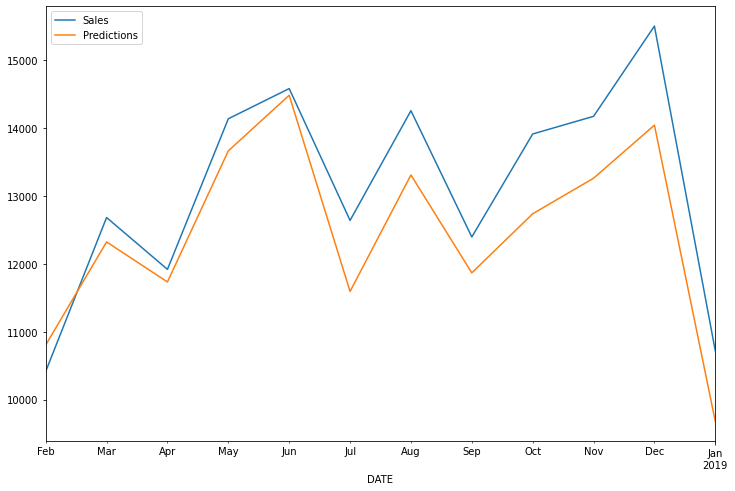

In [54]:
test.plot(figsize=(12,8))

In [55]:
model.save('mycoolmodel.h5')